# Align the Beaded Helix using shapeGMMTorch libraries

In this notebook I will demonstrate how to perform a single maximum likelihood alignment of a trajectory using the shapeGMMTorch libraries.  I will do this for both uniform and kronecker covariance models.

I will use MDAnalysis to read the trajectory but any way of reading a trajectory and generating a `(n_frames, n_atoms, 3)` array is fine.

## Import Libraries

In [1]:
import sys
import numpy as np
# we will use MDAnalysis to read trajectory
import MDAnalysis as md
# the alignment routines are contained in torch_align
from shapeGMMTorch import align
# we will also need to load pytorch to prepare the data
import torch
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Read trajectory

In [2]:
prmtopFileName = "../beaded_helix_example/helix_template.pdb"
trajFileName = "../beaded_helix_example/helix_folding_eps6.0.dcd"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('all')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
traj_numpy = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    traj_numpy[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 12
Number of frames in trajectory: 10001
Number of atoms in selection: 12


## Convert trajectory to a torch tensor and substract center of geometry

In [3]:
# for torch we need to declare the device to perform operation
device = torch.device("cpu")
dtype = torch.float32

In [6]:
# create torch tensor
traj_tensor = torch.tensor(traj_numpy,device=device,dtype=dtype)
# remove COG
traj_tensor = align.remove_center_of_geometry(traj_tensor)

## Uniform alignment

Below I will perform a uniform alignment.  The alignment routine takes in and returns torch tensors.  The routine returns the aligned positions, average, and variance.  If you put `verbose=True` the routine will print the log likelihood of each iteration.

In [8]:
uniform_aligned_traj_tensor, uniform_avg_tensor, uniform_var_tensor = align.maximum_likelihood_uniform_alignment(traj_tensor, verbose=True)

W0616 13:48:41.946000 51351 site-packages/torch/_dynamo/variables/tensor.py:869] [0/1] Graph break from `Tensor.item()`, consider setting:
W0616 13:48:41.946000 51351 site-packages/torch/_dynamo/variables/tensor.py:869] [0/1]     torch._dynamo.config.capture_scalar_outputs = True
W0616 13:48:41.946000 51351 site-packages/torch/_dynamo/variables/tensor.py:869] [0/1] or:
W0616 13:48:41.946000 51351 site-packages/torch/_dynamo/variables/tensor.py:869] [0/1]     env TORCHDYNAMO_CAPTURE_SCALAR_OUTPUTS=1
W0616 13:48:41.946000 51351 site-packages/torch/_dynamo/variables/tensor.py:869] [0/1] to include these operations in the captured graph.
W0616 13:48:41.946000 51351 site-packages/torch/_dynamo/variables/tensor.py:869] [0/1] 
W0616 13:48:41.946000 51351 site-packages/torch/_dynamo/variables/tensor.py:869] [0/1] Graph break: from user code at:
W0616 13:48:41.946000 51351 site-packages/torch/_dynamo/variables/tensor.py:869] [0/1]   File "/opt/anaconda3/lib/python3.12/site-packages/torch/_dynam

Iteration 0: log-likelihood = 14.103167588404263
Iteration 1: log-likelihood = 15.65398371131153
Iteration 2: log-likelihood = 15.699897969225939
Iteration 3: log-likelihood = 15.71642632244557
Iteration 4: log-likelihood = 15.725603387366965
Iteration 5: log-likelihood = 15.730750438849938
Iteration 6: log-likelihood = 15.733635339132457
Iteration 7: log-likelihood = 15.735242854987206
Iteration 8: log-likelihood = 15.736136122127357


In [9]:
# pass tensor back to cpu/numpy
uniform_aligned_traj_numpy = uniform_aligned_traj_tensor.cpu().numpy()
uniform_aligned_avg_numpy = uniform_avg_tensor.cpu().numpy()

## Kronecker alignment

In [10]:
kronecker_aligned_traj_tensor, kronecker_avg_tensor, kronecker_precision_tensor, kronecker_lpdet_tensor = align.maximum_likelihood_kronecker_alignment(traj_tensor, verbose=True)

Iteration 0: log-likelihood = 48.58276069382883
Iteration 1: log-likelihood = 51.03444380784691
Iteration 2: log-likelihood = 51.34662460336414
Iteration 3: log-likelihood = 51.50211685614045
Iteration 4: log-likelihood = 51.625536391117556
Iteration 5: log-likelihood = 51.74200247283133
Iteration 6: log-likelihood = 51.855886260185216
Iteration 7: log-likelihood = 51.95696256832
Iteration 8: log-likelihood = 52.03281231365952
Iteration 9: log-likelihood = 52.08528952027776
Iteration 10: log-likelihood = 52.11929383243846
Iteration 11: log-likelihood = 52.140292759166826
Iteration 12: log-likelihood = 52.15300549389893
Iteration 13: log-likelihood = 52.1606748511513
Iteration 14: log-likelihood = 52.165331487023536
Iteration 15: log-likelihood = 52.16819766450388
Iteration 16: log-likelihood = 52.169996849693554
Iteration 17: log-likelihood = 52.1711562927898
Iteration 18: log-likelihood = 52.17192931205817


In [11]:
kronecker_aligned_traj_numpy = kronecker_aligned_traj_tensor.cpu().numpy()
kronecker_aligned_avg_numpy = kronecker_avg_tensor.cpu().numpy()

# Compare and contrast RMSFs

In [12]:
# calculate RMSF for uniform 
uniform_disp = uniform_aligned_traj_numpy-uniform_aligned_avg_numpy
uniform_disp = np.transpose(uniform_disp,axes=(1,0,2))
uniform_disp = uniform_disp.reshape((-1,uniform_disp.shape[1]*uniform_disp.shape[2]))
uniform_NxN_covar = np.dot(uniform_disp,uniform_disp.T)/(uniform_aligned_traj_numpy.shape[0]-1)
uniform_rmsf = np.sqrt(np.diagonal(uniform_NxN_covar))
# calculate RMSF for uniform 
kronecker_disp = kronecker_aligned_traj_numpy-kronecker_aligned_avg_numpy
kronecker_disp = np.transpose(kronecker_disp,axes=(1,0,2))
kronecker_disp = kronecker_disp.reshape((-1,kronecker_disp.shape[1]*kronecker_disp.shape[2]))
kronecker_NxN_covar = np.dot(kronecker_disp,kronecker_disp.T)/(kronecker_aligned_traj_numpy.shape[0]-1)
kronecker_rmsf = np.sqrt(np.diagonal(kronecker_NxN_covar))

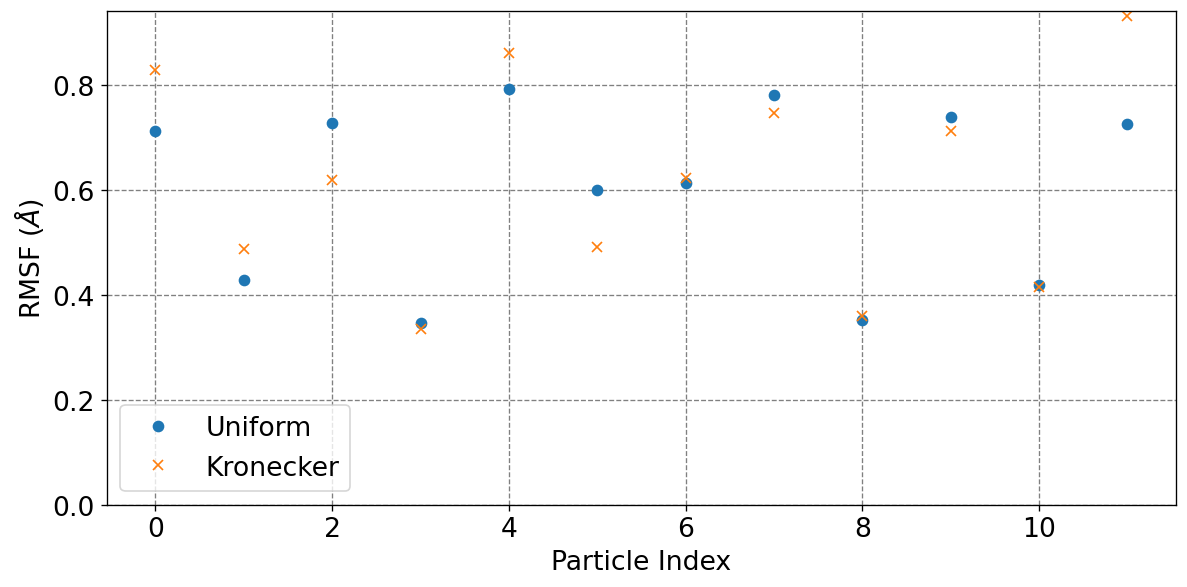

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
# create figure
plt.figure(figsize=(10,5), dpi= 120, facecolor='w', edgecolor='k')
# plot data
plt.plot(uniform_rmsf,'o',label="Uniform")
plt.plot(kronecker_rmsf,'x',label="Kronecker")
# format plot 
plt.grid(which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel(r"RMSF ($\AA$)",fontsize=16)
plt.xlabel("Particle Index",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.legend(fontsize=16)
plt.ylim(0,0.94)
plt.tight_layout()
plt.show();